# ROOT LOCUS ANALYSIS PART 2: PID Design

This notebook introduces the root locus plot and its application to control design.
The notebook extends the root locus to PID design assuming that the design objective is
to minimize the dominant pole and minimize oscillations.

# Preliminaries

In [1]:
#!pip install -q control

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import control
from typing import List, Tuple, Optional

In [3]:
TIMES = np.linspace(0, 10, 100)

# Reference Systems

## 1-Step System

\begin{eqnarray}
S_1 & \xrightarrow{k_1 x_1} & S_2 \\
S_2 & \xrightarrow{k_2 x_2} \emptyset \\
\end{eqnarray}

**Transfer function**
\begin{eqnarray}
G_1 & = & \frac{k_1}{s + k_2} \\
\end{eqnarray}

## 2-Step System

\begin{eqnarray}
S_1 & \xrightarrow{k_1 x_1} & S_2 \\
S_2 & \xrightarrow{k_2 x_2} & S_3 \\
S_3 & \xrightarrow{k_3 x_3} \emptyset \\
\end{eqnarray}

**Transfer function**
\begin{eqnarray}
G_2 & = & \frac{k_1 k_2}{(s + k_2)(s + k_3)} \\
\end{eqnarray}

## Branching System

\begin{eqnarray}
S_1 & \xrightarrow{k_2 x_1} & S_2 \\
S_1 & \xrightarrow{k_3 x_1} & S_3 \\
S_2 & \xrightarrow{k^d_2 x_2} & \emptyset \\
S_3 & \xrightarrow{k^d_3 x_3} & \emptyset \\
\end{eqnarray}

\begin{eqnarray}
H(s) & = & \frac{X_2 (s) + X_3 (s)}{X_1 (s)} \\
& = & (k_2 + k_3) \frac{ s + \frac{k_2 k^d_3 + k_3 k^d_2}{k_2 + k_3}}{s^2 + (k^d_2 + k^d_3)s + k^d_2 k^d_3} \\
\end{eqnarray}

**Observations**
1. Always stable.
2. Never oscillates.
3. Zero at $-\frac{k_2 k^d_3 + k_3 k^d_2}{k_2 + k_3} < 0$.

# Helpers

## plotStep

In [4]:
def plotStep(tf, title:str="", times=TIMES, xlim:Optional[list]=None, figsize=[5,5],
      is_plot=True):
    """
    Plots the step response of the transfer function.

    Args:
        tf - transfer function
    """
    _, ax = plt.subplots(1, 1, figsize=figsize)
    _, yv = control.step_response(tf, T=times)
    _ = ax.plot(times, yv)
    if xlim is not None:
        ax.set_xlim(xlim)
    _ = ax.set_title(title)
    if not is_plot:
        plt.close()

# TESTS
tf = control.TransferFunction([5], [1, 5])
plotStep(tf, is_plot=False, xlim=[0, 3])
print("OK!")

OK!


## complex_magnitude

In [5]:
def complex_magnitude(z):
    return (z.real**2 + z.imag**2)**0.5

## ppComplex

In [6]:
def ppComplex(complexes:np.ndarray, round_digits=3)->str:
    """
    Constructs a pretty print representation of a complex number.
    """
    complexes = np.array(complexes)
    complexes = complexes.flatten()
    if not isinstance(complexes, list):
        complexes = [complexes]
    results = []
    if isinstance(complexes[0], np.ndarray):
        complexes = complexes[0]
    for cmpx in complexes:
        try:
            if np.imag(cmpx) == 0:
                results.append(str(round(np.real(cmpx), round_digits)))
            else:
                 results.append(str(round(np.real(cmpx), round_digits)) + "+" + str(round(np.imag(cmpx), round_digits)) + "j")
        except:
            import pdb; pdb.set_trace()
    return ", ".join(results)

# Tests
result = ppComplex((-1.9999999999999998+0j))
result = ppComplex([3+2j, 4])
assert("j" in result)
print("OK!")

OK!


## plotRootLocusWithGains

In [7]:
def plotRootLocusWithGains(open_loop_transfer_function:control.TransferFunction,
      gains:List[float],
      xlim:Optional[np.ndarray]=None,
      title:Optional[str]=None,
      ylim:Optional[np.ndarray]=None,
      is_annotate:bool=True,
      markersize_multiplier:float=100,
      figsize=(5, 5),
      fontsize=10,
      ax=None,
      is_plot:bool=True)->plt.axes:
    """
    Constructs a root locus plot with red hexagons for closed loop poles at different gains.
    Poles at specific gains are indicated by hexigon markers.

    Args:
        open_loop_transfer_function
        gains
        xlim: limits on the axis
        size_multiplier: multiplies by gain to get size of hexagon that marks the pole
        figsize: width and height of figure
        is_annotate: Annotate gain hexigons with gain values
    """
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    # Plot the root locus
    _ = control.root_locus(open_loop_transfer_function, grid=False, plot=True, xlim=xlim,
          ylim=ylim, ax=ax)
    # Construct the title
    if title is None:
        poles = open_loop_transfer_function.poles()
        zeros = open_loop_transfer_function.zeros()
        title = ""
        if len(poles) > 0:
            title += f"FFL poles: {ppComplex(poles)}  "
        if len(zeros) > 0:
            title += f"FFL zeros: {ppComplex(zeros)}"
    ax.set_title(title, size=fontsize)
    # Add points for closed loop poles
    for gain in gains:
        closed_loop_transfer_function = control.feedback(gain*open_loop_transfer_function)
        poles = closed_loop_transfer_function.poles()
        xv = []
        yv = []
        for pole in poles:
            xv.append(pole.real)
            yv.append(pole.imag)
        if is_annotate:
            annotation = str(gain)
        else:
            annotation = ""
        ax.scatter(xv, yv, s=markersize_multiplier*gain, marker="h", color="r")
        [ ax.annotate(annotation, (xv[i], yv[i]), color='blue', rotation=25)
             for i in range(len(poles))]
        arrowprops=dict(facecolor='black', shrink=0.05)
    # Plot at zero
    ax.plot([0, 0], [-10, 10], color="grey", linestyle="--")
    #
    if not is_plot:
        plt.close()
        ax = None
    return ax

# Tests
tf = control.zpk([1], [-1, -2], [1])
plotRootLocusWithGains(tf, [0.2, 0.5], markersize_multiplier=200, ylim=[-3, 3], xlim=[-3.5, 0], is_annotate=True,
      figsize=(2, 2), is_plot=False)
print("OK!")

OK!


# Running Example


    s + 1
-------------
s^2 + 5 s + 6



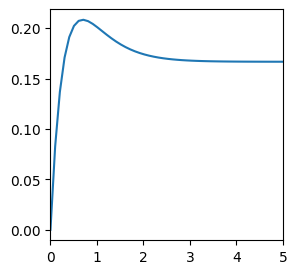

In [8]:
# Illustrative: Branching system
OL_TF = control.zpk([-1], [-2, -3], [1])
print(OL_TF)
plotStep(OL_TF, figsize=(3,3), xlim=[0, 5])

In [9]:
OL_TF.poles()

array([-3.+0.j, -2.+0.j])

In [10]:
OL_TF.zeros()

array([-1.+0.j])

# Summary of Root Locus Analysis

The root locus plot displays the poles of the *closed loop* transfer function for the open loop under p-control.
* x-axis is the real part of the pole
* y-axis is the imaginary part of the pole
* Open loop poles are indicated by an "X"
* Open loop zeros are indicated by a red circle
* Blue lines are "branches" the path of closed loop poles as $k_P$ is changed

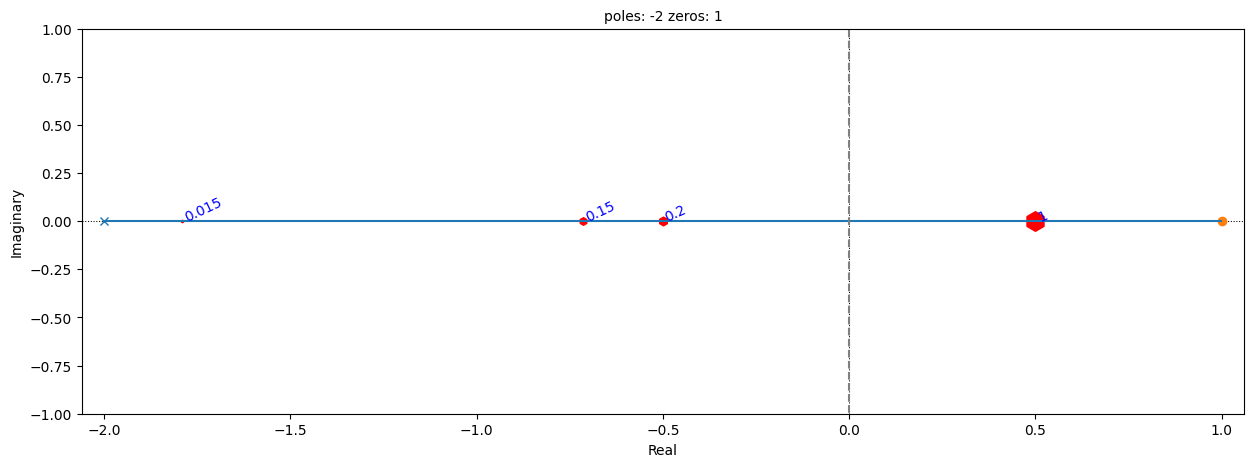

In [11]:
ol_tf = control.zpk([1], [-2], [5])
_ = plotRootLocusWithGains(ol_tf, gains=[0.015, 0.15, 0.2, 1], markersize_multiplier=200, title="poles: -2 zeros: 1",
    figsize=(15, 5),
     is_annotate=True)

A point at which a branch leaves the x-axis is a **breakaway point**.
A point at which a branch joins the x-axis is a **breakin point**.

<Axes: title={'center': 'FFL poles: -4.0, -3.0  '}, xlabel='Real', ylabel='Imaginary'>

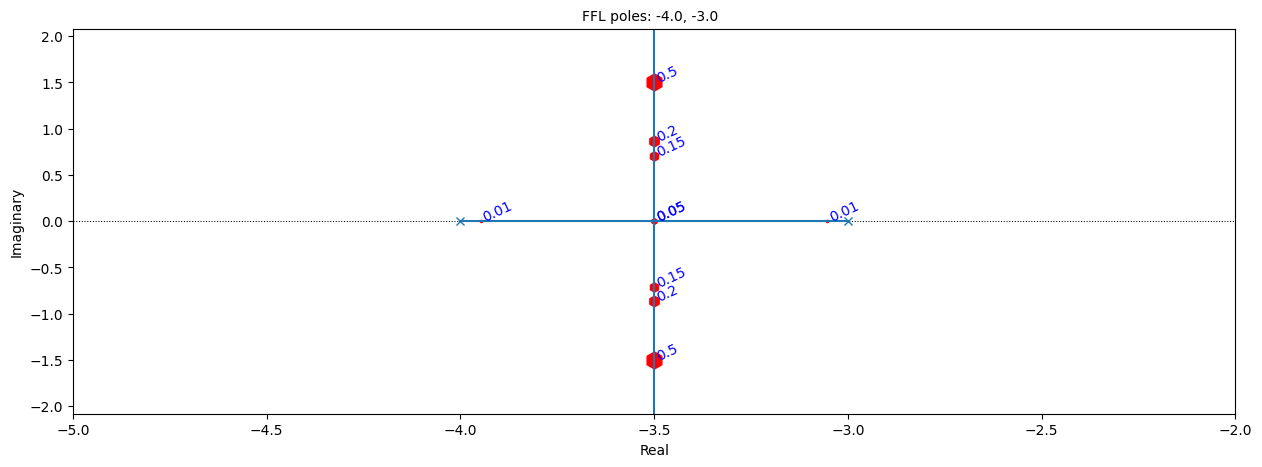

In [12]:
ol_tf = control.zpk([], [-3, -4], [5])
plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 0.5], markersize_multiplier=300,
    xlim=[-5, -2], figsize=[15, 5], is_annotate=True)

### 1. Branches begin at open loop poles and terminate at open loop zeros or infinity.

### 2. The root locus plot is symmetric about the x-axis.

### 3. A branch exists on the real axis if there are an odd number of poles and zeroes to the right

### 4. Angle of asymptotes is $\alpha$ s.t. $(N_P - N_Z) \alpha = \pm 180 + k*360$

**Key insights**
1. The smallest pole you can get is the minimum of the largest open loop zero and the largest open loop pole.
2. I-control adds a pole at 0. So, this becomes the largest open loop pole.
3. Sometimes, you can eliminate a pole by a control technique called "pole-zero" cancelation.

# Designing With Root Locus Analysis

## Theory

**Design objective: Minimize the dominant pole.**

DC gain must be addressed separately (e.g., high gain P-control or use I-control).

**Derivation**

Observe that we add a pole at 0 with I-control.

\begin{eqnarray}
C(s) & = & k_P + \frac{k_I}{s} + s k_D \\
& = & \frac{k_I + k_P s + k_D s^2}{s}
\end{eqnarray}

The zeros of $C(s)$ are
\begin{eqnarray}
k_I + k_P s + k_D s^2 & = & 0 \\
z_C & = & \frac{1}{2} \left( -k_P \pm \sqrt{k_P^2 - 4 k_I k_D} \right ), \\
\end{eqnarray}
where $z_C$ are the zeros introduced by the controller.

Let $z$ be the zeros of $G(s)$. Then, at high gain, the closed loop poles are at $max \{ z_C, z \}$.
Thus, in general, we want to choose $k_P, k_I, k_D$ so that we minimize $max~ z_C$.
This is done by:
* Choosing a large $k_P$.
* Choosing $k_I, k_D$ such that $k_P^2 = 4 k_I k_D$.

Let $G(s)$ be the open loop transfer function.
The **feedforward transfer function** is $C(s) G(s)$. It appears in the numerator and denominator of $H(s)$.

Let $G(s) = \frac{N(s)}{D(s)}$, where the the open loop zeros are the $s$ such $N(s) = 0$ and the open loop poles
are the $s$ such that $D(s) = 0$.
The feedfoward transfer function is
\begin{eqnarray}
C(s)G(s) & = & \frac{k_I + k_P s + k_D s^2}{s} G(s) \\
& = & \frac{(k_I + k_P s + k_D s^2) N(s)}{s + s D(s)}
\end{eqnarray}

\begin{eqnarray}
H(s) & = & \frac{C(s)G(s)}{1 + C(s) G(s)} \\
& = & \frac{(k_I + k_P s + k_D s^2) N(s)}{s D(s) + (k_I + k_P s + k_D s^2)   N(s)} \\
& = &  \frac{k_P(r_{IP} + s + r_{DP} s^2) N(s)}{s D(s) +  k_P(r_{IP} + s + r_{DP} s^2) N(s)} \\
\end{eqnarray}

* $r_{IP} = \frac{k_I}{k_P}$
* $r_{DP} = \frac{k_D}{k_P}$

## PI

### Theory

**Feedforward transfer function**
The open loop transfer function includes a parameterized form of the controller.
\begin{eqnarray}
C(s) & = & \frac{k_P (r_{IP} + s)}{s} \\
C(s)G(s) & = & \frac{k_P(r_{IP} + s) N(s)}{s D(s)} \\
\end{eqnarray}

* Open loop zeros at $N(s) = 0$ and $-\frac{k_I}{k_P}$
* Open loop poles at $D(s) = 0$ and 0.

The design parameters are $k_P$, $r_{IP}$.

\begin{eqnarray}
H(s) & = & \frac{C(s)G(s)}{1 + C(s) G(s)} \\
& = & \frac{k_P (r_{IP} + s) N(s)}{s D(s) +  k_P (r_{IP} + s)  N(s)} \\
\end{eqnarray}

**Observations**
1. I-control ensures that DC gain is 1.
1. Need large $k_I$ and/or $k_P$ to move away from the pole at zero.
2. If $N(s)$ zeros are sufficiently negative, use large $k_I$ and/or $k_P$.
3. Note that negative open loop poles don't help us because we need large gains to address the pole at 0.

### Example

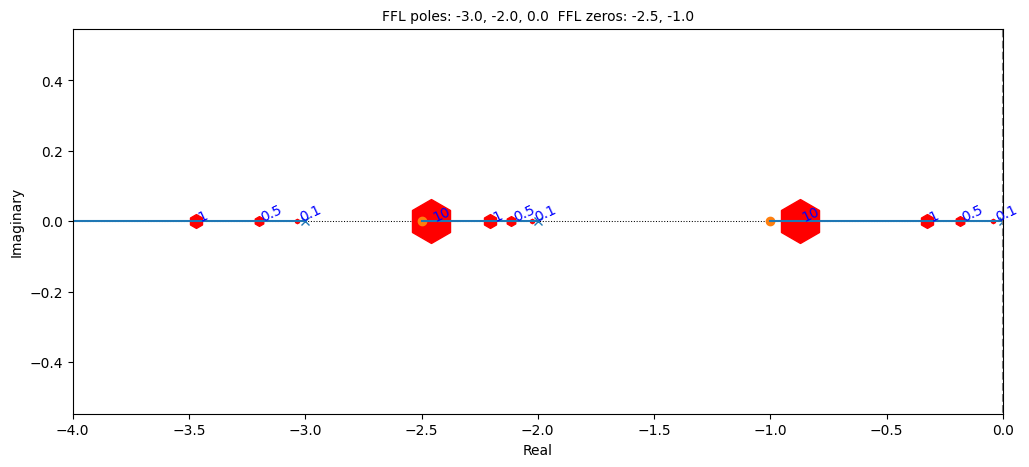

In [13]:
rIP = 2.5
controller_tf = control.TransferFunction([1, rIP], [1, 0])
_ = plotRootLocusWithGains(controller_tf*OL_TF, gains=[0.1, 0.5, 1, 10], xlim=[-4, 0], figsize=[12, 5],
                         )

### Design strategy

1. We have an open loop pole at 0 from I-control. So, we need to make the open loop zeros as small as possible.
2. We are limited by the open loop zeros of $G(s)$.
3. Expore $r_{IP}$ to make the maximum open loop zero no larger than the largest open loop zero of $G(s)$.

## PD

Not including I-control, means that we must consider DC gain. This can be done by having large values for $k_D$ and/or $k_P$.

### Theory

**Feedforward transfer function**
The open loop transfer function includes a parameterized form of the controller.
\begin{eqnarray}
C(s) & = & k_P (1 + r_{DP} s) \\
C(s)G(s) & = & \frac{ k_P (1 + r_{DP} s) N(s)}{D(s)} \\
\end{eqnarray}

* Open loop zeros at $N(s) = 0$ and $-\frac{1}{r_{DP}}$
* Open loop poles at $D(s) = 0$ and 0.

The design parameters are $k_P$, $r_{DP}$.

\begin{eqnarray}
H(s) & = & \frac{C(s)G(s)}{1 + C(s) G(s)} \\
& = & \frac{ k_P (1 + r_{DP} s) N(s)}{ D(s) +   k_P (1 + r_{DP} s)  N(s)} \\
\end{eqnarray}

where $r_{DP} = \frac{k_D}{k_P}$.

### Example

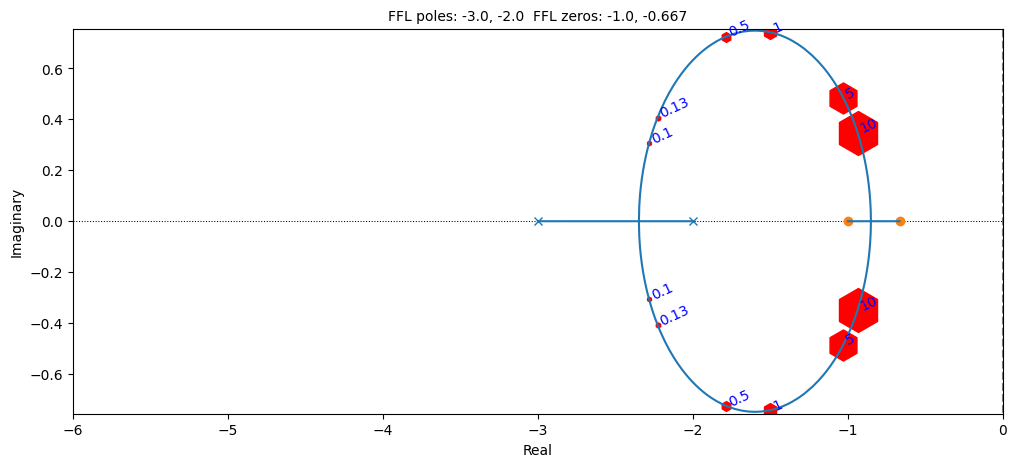

In [14]:
# Strategy 1: Position near the breakaway point, and move the breakaway point to the left.
rDP = 1.5
controller1_tf = control.TransferFunction([rDP, 1], [1])
_ = plotRootLocusWithGains(controller1_tf*OL_TF, gains=[0.1, 0.13, 0.5, 1, 5, 10], xlim=[-6, 0], figsize=[12, 5])

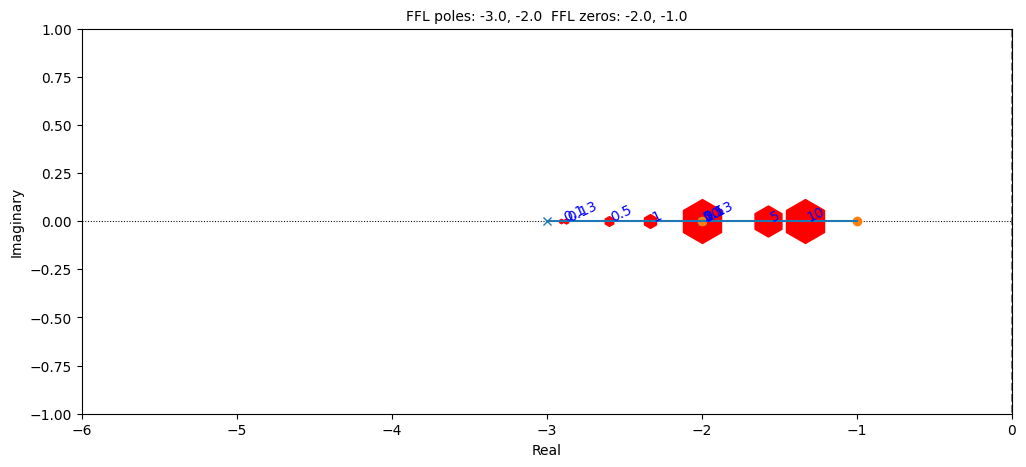

In [15]:
# Strategy 2: Cancel the larger pole by having kP/kD = 2, or rDP = 0.5
rDP = 0.5
controller2_tf = control.TransferFunction([rDP, 1], [1])
_ = plotRootLocusWithGains(controller2_tf*OL_TF, gains=[0.1, 0.13, 0.5, 1, 5, 10], xlim=[-6, 0], figsize=[12, 5])

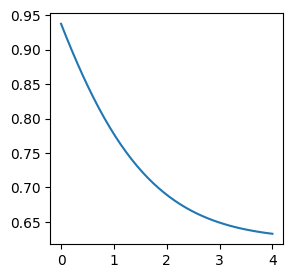

<Figure size 640x480 with 0 Axes>

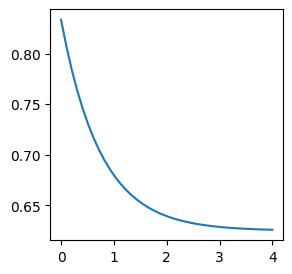

In [16]:
kP = 10
times = np.linspace(0, 4, 40)
cl_tf = control.feedback(kP*controller1_tf*OL_TF)
_ = plotStep(cl_tf, times=times, figsize=(3,3))
_ = plt.figure()
cl_tf = control.feedback(kP*controller2_tf*OL_TF)
_ = plotStep(cl_tf, times=times, figsize=(3,3))

The second plot converges faster.

Strategy

1. Need large $k_P$ and/or $k_D$ to assure DC gain is 1.
1. Strategy 1: Make  $-\frac{1}{r_{DP}}$ very negative to push the poles to the left, which means $k_D$ is large.
2. Strategy 2: Choose  $-\frac{1}{r_{DP}}$ to equal to the largest pole in $D(s)$ to cancel the pole in $G(s)$.

## PID

### Theory

\begin{eqnarray}
H(s) & = & \frac{C(s)G(s)}{1 + C(s) G(s)} \\
& = & \frac{(k_I + k_P s + k_D s^2) N(s)}{s D(s) + (k_I + k_P s + k_D s^2)   N(s)} \\
& = &  \frac{k_P(r_{IP} + s + r_{DP} s^2) N(s)}{s D(s) +  k_P(r_{IP} + s + r_{DP} s^2) N(s)} \\
\end{eqnarray}

* $r_{IP} = \frac{k_I}{k_P}$
* $r_{DP} = \frac{k_D}{k_P}$

We should be able to do better since the smallest open loop zero is -1.
The imaginary zeroes come from the controller. We can adjust controller parameters so that its zero is -1.

The zeros of $C(s)$ are
\begin{eqnarray}
k_I + k_P s + k_D s^2 & = & 0 \\
z_C & = & \frac{1}{2} \left( -k_P \pm \sqrt{k_P^2 - 4 k_I k_D} \right ), \\
\end{eqnarray}
where $z_C$ are the zeros introduced by the controller.

We can solve to find when $z_C = -1$ to cancel the pole at $-1$.

<Axes: title={'center': 'FFL poles: -3.0  '}, xlabel='Real', ylabel='Imaginary'>

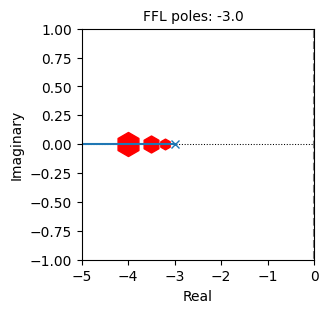

In [18]:
ol_tf = control.zpk([], [-3], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 3),
    xlim=[-5, 0], is_annotate=False)

**Approach**: Find $k_P$ at the breakaway point.

<Axes: title={'center': 'poles: -3, -4'}, xlabel='Real', ylabel='Imaginary'>

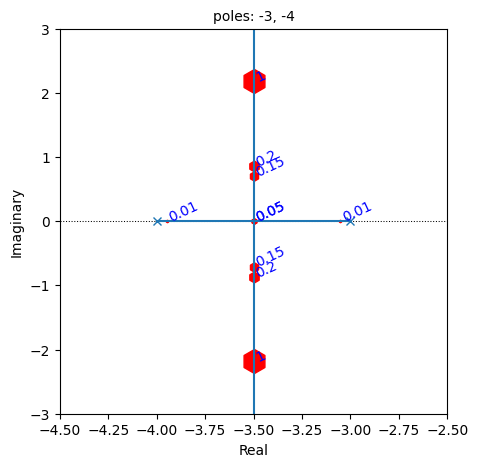

In [19]:
ol_tf = control.zpk([], [-3, -4], [5])
plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300, title="poles: -3, -4",
    xlim=[-4.5, -2.5], ylim=[-3, 3], is_annotate=True)

**Approach**:
1. If $z > max(p_1, p_2)$, minimize $k_P$.
2. If $p_1 < z < p_2$, choose $k_P$ so that dominant closed loop pole is close to $z$.
3. If $z < p_1 < p_2$, choose $k_P$ at the breakin point.

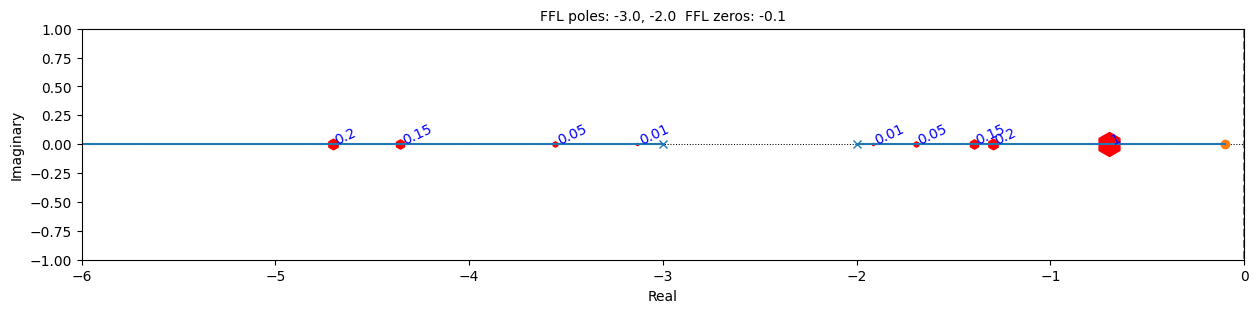

In [20]:
# Case 1: p1, p2 < z
ol_tf = control.zpk([-0.1], [-2, -3], [5])
_ = plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300,
    xlim=[-6, 0], figsize=(15, 3), is_annotate=True)

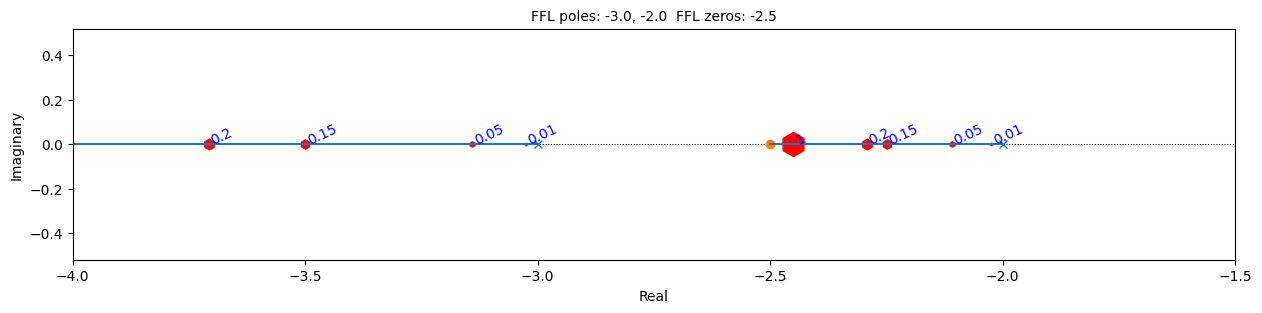

In [21]:
# Case 2: p1 < z < p2
ol_tf = control.zpk([-2.5], [-2, -3], [5])
_ = plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300,
    xlim=[-4, -1.5], figsize=(15, 3), is_annotate=True)

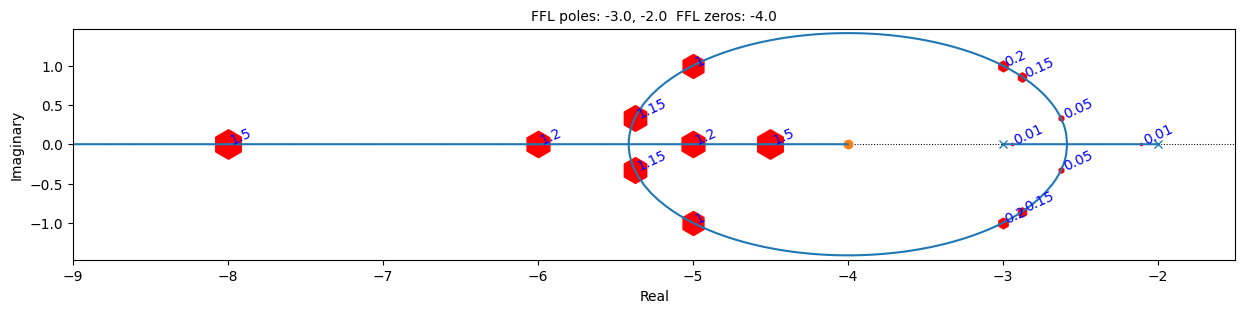

In [22]:
# Case 3: z < p1, p2
ol_tf = control.zpk([-4], [-2, -3], [5])
_ = plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1, 1.15, 1.2, 1.5], markersize_multiplier=300,
    xlim=[-9, -1.5], figsize=(15, 3), is_annotate=True)

### Search

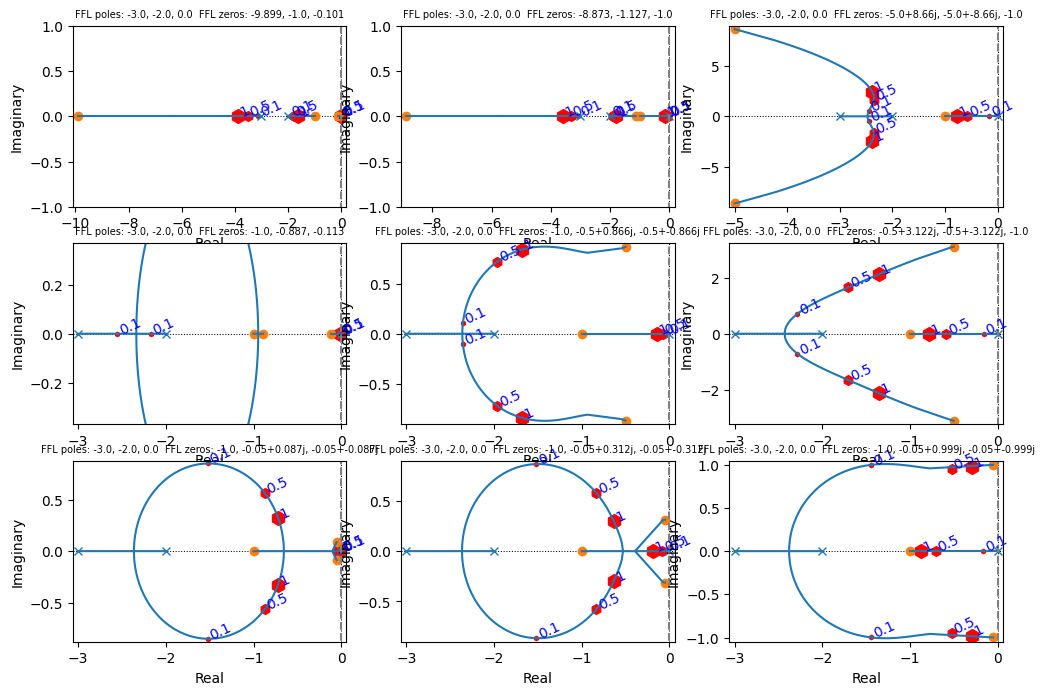

In [23]:
# Plots at different rIP, rDP
s = control.TransferFunction.s
RIP_VALUES = [0.1, 1, 10]
RDP_VALUES = [0.1, 1, 10]
num_xpos = len(RDP_VALUES)
num_ypos = len(RIP_VALUES)
_, axes = plt.subplots(num_xpos, num_ypos, figsize=(12, 8))
xpos = 0
ypos = 0
gains = [0, 0.1, 1]
for rIP in RIP_VALUES:
    for rDP in RDP_VALUES:
        ax = axes[xpos, ypos]
        controller_tf = (rIP + s + rDP*s**2)/s
        ff_tf = controller_tf*OL_TF
        _ = plotRootLocusWithGains(ff_tf, [.1, 0.5, 1] , ax=ax, fontsize=7)
        xpos += 1
        if xpos >= len(RDP_VALUES):
            xpos = 0
            ypos += 1